# Прогнозирование оттока клиентов

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Задача — обучить на этих данных модель для прогноза оттока клиентов.

### Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

**Информация о договоре**
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Персональные данные клиента**
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Информация об интернет-услугах**
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Информация об услугах компании**
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

### План работы

1. Загрузить данные из разных источников.
2. Ознакомиться с каждым набором данных, провести предобработку.
3. Объединить данные.
4. Провести исследовательский анализ данных объединенного набора.
5. Подготовить данные для обучения моделей ML.
6. Выбрать и обучить несколько моделей.
7. Выбрать лучшую модель.
8. Сформулировать заключительный вывод.

## Загрузка и предобработка данных

🚩 Библиотека lightgbm
- должна быть версии >= 4.0.0, т.к. в коде категориальные столбцы приводятся к типу *category* и используются как есть без предварительного перекодирования в типу *integer*.
- код обновления lightgbm протестирован в тренажере.

In [1]:
!pip install -U -q lightgbm
!pip install -U -q phik

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier, __version__ as light_version

import phik
from phik.report import plot_correlation_matrix

import os

import re

In [3]:
print('Версия LightGBM:', light_version)

Версия LightGBM: 4.1.0


In [4]:
DIRS = ['datasets/', '/datasets/']
ADDR = 'https://code.s3.yandex.net/datasets/'

UPLOAD_DATE = '2020-02-01'

TEST_SIZE = 0.25
TEST_THRESHOLD = 0.85

RANDOM_STATE = 301023

In [5]:
def get_path(file):
    for dir in DIRS:
        full_path = dir + file
        if os.path.exists(full_path):
            break
    else:
        full_path = ADDR + file
        
    return full_path

In [6]:
try:
    data_contract = pd.read_csv(get_path('contract_new.csv'))
    data_personal = pd.read_csv(get_path('personal_new.csv'))
    data_internet = pd.read_csv(get_path('internet_new.csv'))
    data_phone = pd.read_csv(get_path('phone_new.csv'))
except Exception as e:
    print('Error loading data:', e)

In [7]:
def describe(df):
    display(df.sample(5, random_state=RANDOM_STATE))
    df.info()

def to_snack_case(name):
    return re.sub(r'(\w)([A-Z]+)', r'\1_\2', name).lower()

def rename_cols(df):
    df.columns = df.columns.map(to_snack_case)
    
def set_index(df):
    df.set_index('customer_id', inplace=True)
    print('Кол-во дубликатов индекса: ', df.index.duplicated().sum())
    
def check_cats(df):
    print('Уникальные значения категорий:')
    
    for cat in df.select_dtypes(include='object').columns:
        print(f'{cat}: {df[cat].unique().tolist()}')
        
def to_datetime(df, col):
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

### Информация о договоре

In [8]:
describe(data_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5656,7312-XSBAT,2020-01-01,No,Month-to-month,No,Electronic check,49.75,49.75
6616,9600-NAXZN,2016-06-01,2017-05-01,Month-to-month,Yes,Electronic check,101.40,1204.63
224,5961-VUSRV,2019-02-01,No,One year,Yes,Bank transfer (automatic),19.35,232.2
6077,8085-MSNLK,2014-12-01,No,Two year,No,Mailed check,113.95,7488.79
3104,6860-YRJZP,2019-05-01,No,Month-to-month,Yes,Electronic check,74.05,699.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
rename_cols(data_contract)
set_index(data_contract)

Кол-во дубликатов индекса:  0


Приведем столбцы дат к типу *datetime64*. Часть полей являются строками *No*, установим им значение NaT.

In [10]:
to_datetime(data_contract, 'begin_date')
to_datetime(data_contract, 'end_date')

Приведем столбец `total_charges` к типу *float64*. Часть полей являются пустыми строками, установим им значение *NaN*.

In [11]:
# Использование errors='coerce' позволит установить NaN для ошибок приведения типов (для пустых строк)
data_contract['total_charges'] = pd.to_numeric(data_contract['total_charges'], errors='coerce')

Часть клиентов пользовалась услугами меньше месяца: у них дата начала равна дате выгрузки (последней дате). Значения общих расходов еще не определены только для этой категории клиентов.

In [12]:
data_contract.query('total_charges.isna()')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN


In [13]:
check_cats(data_contract)

Уникальные значения категорий:
type: ['Month-to-month', 'One year', 'Two year']
paperless_billing: ['Yes', 'No']
payment_method: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']


### Персональные данные клиента

In [14]:
describe(data_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
5656,7312-XSBAT,Male,0,No,No
6616,9600-NAXZN,Male,0,No,No
224,5961-VUSRV,Female,0,No,No
6077,8085-MSNLK,Female,0,Yes,No
3104,6860-YRJZP,Male,1,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
rename_cols(data_personal)
set_index(data_personal)

Кол-во дубликатов индекса:  0


Приведем значения столбца *senior_citizen* к Yes/No, как это принято для всех бинарных категориальных столбцов набора.

In [16]:
data_personal['senior_citizen'] = data_personal['senior_citizen'].map({0: 'No', 1: 'Yes'})

In [17]:
check_cats(data_personal)

Уникальные значения категорий:
gender: ['Female', 'Male']
senior_citizen: ['No', 'Yes']
partner: ['Yes', 'No']
dependents: ['No', 'Yes']


### Информация об интернет-услугах

In [18]:
describe(data_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
264,4983-CLMLV,Fiber optic,No,Yes,No,Yes,Yes,Yes
1567,3365-SAIGS,Fiber optic,No,Yes,No,No,Yes,No
1211,9327-QSDED,DSL,No,No,No,No,No,No
1200,2811-POVEX,Fiber optic,No,Yes,Yes,No,No,Yes
1482,2039-JONDJ,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
rename_cols(data_internet)
set_index(data_internet)
check_cats(data_internet)

Кол-во дубликатов индекса:  0
Уникальные значения категорий:
internet_service: ['DSL', 'Fiber optic']
online_security: ['No', 'Yes']
online_backup: ['Yes', 'No']
device_protection: ['No', 'Yes']
tech_support: ['No', 'Yes']
streaming_tv: ['No', 'Yes']
streaming_movies: ['No', 'Yes']


### Информация об услугах телефонии

In [20]:
describe(data_phone)

,customerID,MultipleLines
5445,3727-RJMEO,Yes
2710,3043-TYBNO,No
389,5886-VLQVU,Yes
6261,6508-NJYRO,No
5797,0807-ZABDG,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
rename_cols(data_phone)
set_index(data_phone)
check_cats(data_phone)

Кол-во дубликатов индекса:  0
Уникальные значения категорий:
multiple_lines: ['No', 'Yes']


### Охват клиентов услугами

In [22]:
indexes = data_contract.index.difference(data_phone.index.union(data_internet.index))
print(f'Число клиентов не имеющих ни одной услуги: {len(indexes)}')

Число клиентов не имеющих ни одной услуги: 0


### Выводы

- Данные представлены четырьмя наборами: клиенты, договоры, услуги интернета, подключение к телефонии.
- Названия столбцов в стиле CamelCase приведены к стилю snake_case.
- Столбцы дат начала и окончания договора приведены к типу *datetime64*.
- Столбец общих расходов приведен к типу *float64*.
- Дубликаты отсутствуют: идентификатор клиента уникален для всех наборов данных.
- Проверены уникальные значения категорий: дубликатов нет.
- Для клиентов, пользующихся услугами меньше месяца, общие расходы еще не определены.
- Клиенты, которые еще не расторгли договор, имеют пустую дату окончания.
- Все клиенты имеют договоры, не все клиенты имеют стационарную телефонную связь, также не все подписаны на услуги интернета.

## Объединение данных

Добавим дополнительный признак наличия телефона в объединенную таблицу, т.к. отсутствие опции многоканального телефона еще не говорит об отсутствии услуги телефонии. Наличие интернета будет определяться столбцом `internet_service`.

In [23]:
# Признак наличия телефона
data_phone['phone'] = 'Yes'
# Объединенный датафрейм
data = (
    data_contract
    .join(data_personal)
    .join(data_internet, how='left')
    .join(data_phone, how='left')
)

## EDA объединенного датафрейма

In [24]:
describe(data)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone
customer_id,,,,,,,,,,,,,,,,,,,,
7312-XSBAT,2020-01-01,NaT,Month-to-month,No,Electronic check,49.75,49.75,Male,No,No,No,DSL,Yes,No,No,No,No,No,No,Yes
9600-NAXZN,2016-06-01,2017-05-01,Month-to-month,Yes,Electronic check,101.40,1204.63,Male,No,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,Yes
5961-VUSRV,2019-02-01,NaT,One year,Yes,Bank transfer (automatic),19.35,232.20,Female,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
8085-MSNLK,2014-12-01,NaT,Two year,No,Mailed check,113.95,7488.79,Female,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6860-YRJZP,2019-05-01,NaT,Month-to-month,Yes,Electronic check,74.05,699.77,Male,Yes,No,No,Fiber optic,No,No,No,No,No,No,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

### Пустые значения

В столбцах интернета и телефонии могут появиться пустые значения после объединения наборов данных. Можно считать, что пустые значения означают, что пользователь не подписан на данные услуги. Заполним эти столбцы значением *No*.

In [25]:
# Заполняем пустые услуги
cols = data.select_dtypes(include='object').columns
data[cols] = data[cols].fillna('No')

Для клиентов, пользующихся услугами меньше месяца, общие расходы `total_charges` еще не определены. Заполним их значениями расходов за месяц.

In [26]:
data.loc[data.query('total_charges.isna()').index, 'total_charges'] = data['monthly_charges']

### Новые столбцы

Добавим новый бинарный столбец `target`: клиент ушел - 1, нет - 0. Данный столбец будет целевым признаком для моделей ML.

In [27]:
data['target'] = data['end_date'].notna().astype('int64')

Добавим новый столбец `period`: сколько дней клиент пользовался услугами. Если клиент еще не ушел, то датой окончания будет являться дата выгрузки данных.

In [28]:
data['period'] = (
    data['end_date'].fillna(pd.to_datetime(UPLOAD_DATE)) - data['begin_date']
).dt.days

Добавим новый столбец `option_count` - количество опций по двум типам услуг: интернет и телефония.

In [29]:
option_cols = ['online_security', 'online_backup', 'device_protection',\
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
data['option_count'] = data[option_cols].map(lambda x: 1 if x == 'Yes' else 0).sum(axis=1)

### Распределения признаков

In [30]:
target_dict = {0: 'Остался', 1: 'Ушел'}

def bar_ax(df, ax, title, rot=0, color=None, legend=False):
    ax.set_ylabel('Частота')
    return df.plot.bar(ax=ax, title=title, grid=True, rot=rot, xlabel='', color=color, legend=legend)

def bar(df, column, ax, title, normalize=False, rot=0, color=None):
    df_vc = df[column].value_counts(normalize=normalize).sort_index()
    return bar_ax(df_vc, ax, title, rot, color)

def bar_target(df,
               column,
               ax, title,
               normalize=True, rot=0, ascending=False, color=None, legend=False):
    df_pt = df.pivot_table(
        index=column, values='begin_date', columns='target', aggfunc='count'
    ).rename(columns=target_dict).sort_index(ascending=ascending)
    if normalize:
        df_pt /= df_pt.sum(axis=0)
    return bar_ax(df_pt, ax, title, rot, color, legend)

def hist_ax(ax, x, label, density=True):
    ax.hist(x, bins=10, alpha=0.7, label=label, density=density)
    ax.legend([])

def hist_target(df, column, ax, title):
    for key, value in target_dict.items():
        hist_ax(ax, df.query('target == @key')[column], label=value)
    ax.set_title(title)
    ax.get_legend().remove()
    ax.grid()
    ax.set_ylabel('Частота')

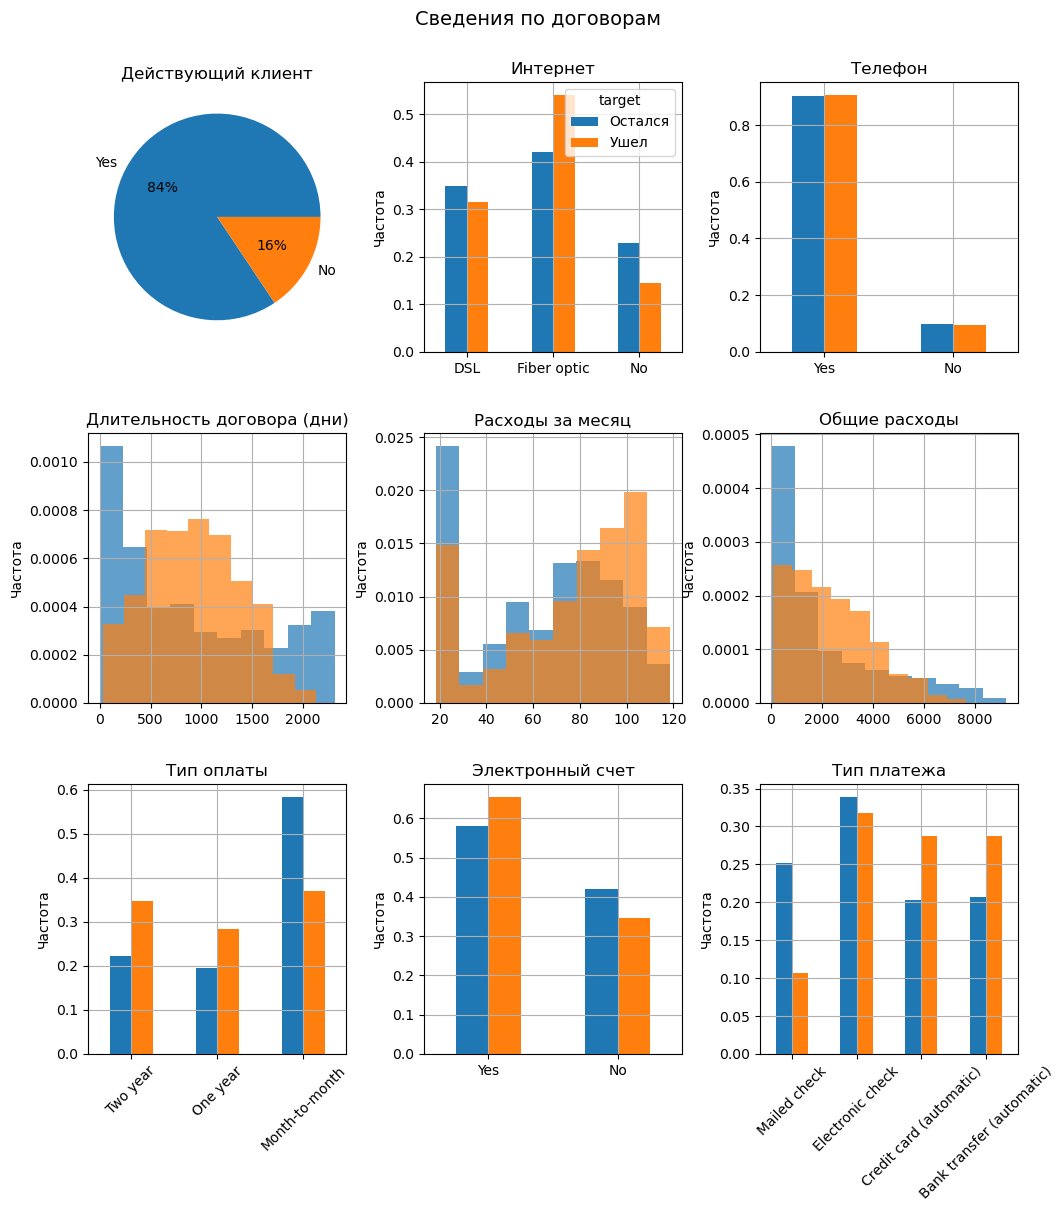

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

(
    data['target']
    .value_counts(normalize=True)
    .sort_index()
    .plot
    .pie(ax=axes[0][0], title='Действующий клиент', labels=['Yes', 'No'], autopct='%.0f%%')
    .set(ylabel='')
)

bar_target(data, 'internet_service', axes[0][1], 'Интернет', ascending=True, legend=True)
bar_target(data, 'phone', axes[0][2], 'Телефон')

hist_target(data, 'period', axes[1][0], 'Длительность договора (дни)')
hist_target(data, 'monthly_charges', axes[1][1], 'Расходы за месяц')
hist_target(data, 'total_charges', axes[1][2], 'Общие расходы')

bar_target(data, 'type', axes[2][0], 'Тип оплаты', rot=45)
bar_target(data, 'paperless_billing', axes[2][1], 'Электронный счет')
bar_target(data, 'payment_method', axes[2][2], 'Тип платежа', rot=45)

fig.suptitle('Сведения по договорам', fontsize=14)
plt.subplots_adjust(top=0.92, wspace=0.3, hspace=0.3)
plt.show()

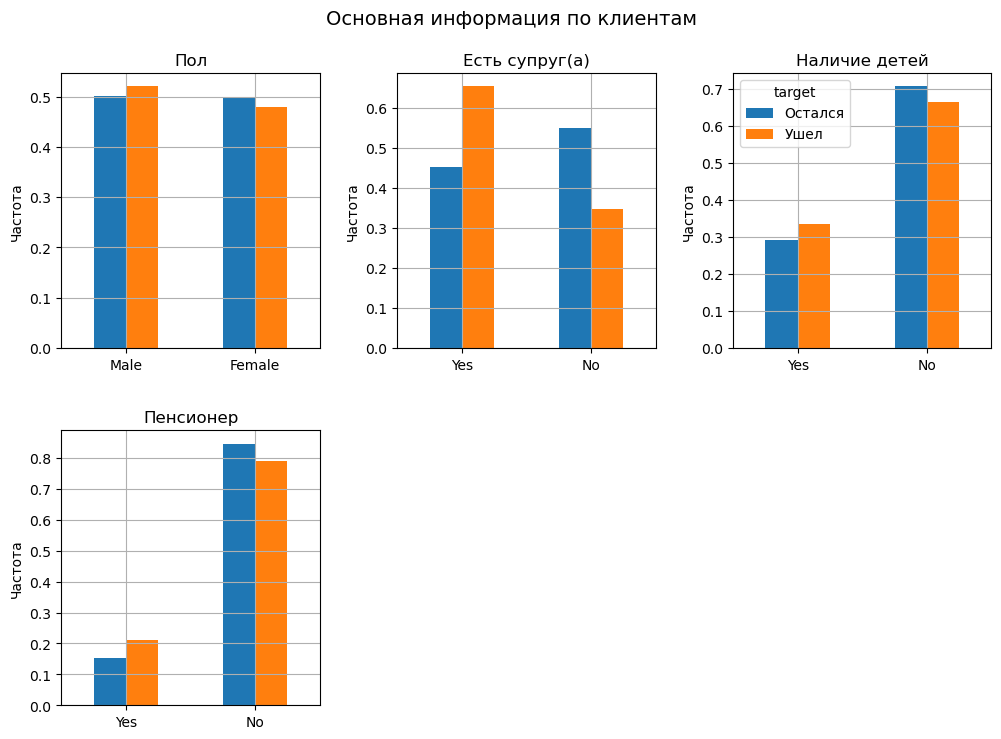

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

bar_target(data, 'gender', axes[0][0], 'Пол')
bar_target(data, 'partner', axes[0][1], 'Есть супруг(а)')
bar_target(data, 'dependents', axes[0][2], 'Наличие детей', legend=True)

bar_target(data, 'senior_citizen', axes[1][0], 'Пенсионер')
axes[1][1].set_visible(False)
axes[1][2].set_visible(False)

fig.suptitle('Основная информация по клиентам', fontsize=14)
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)
plt.show()

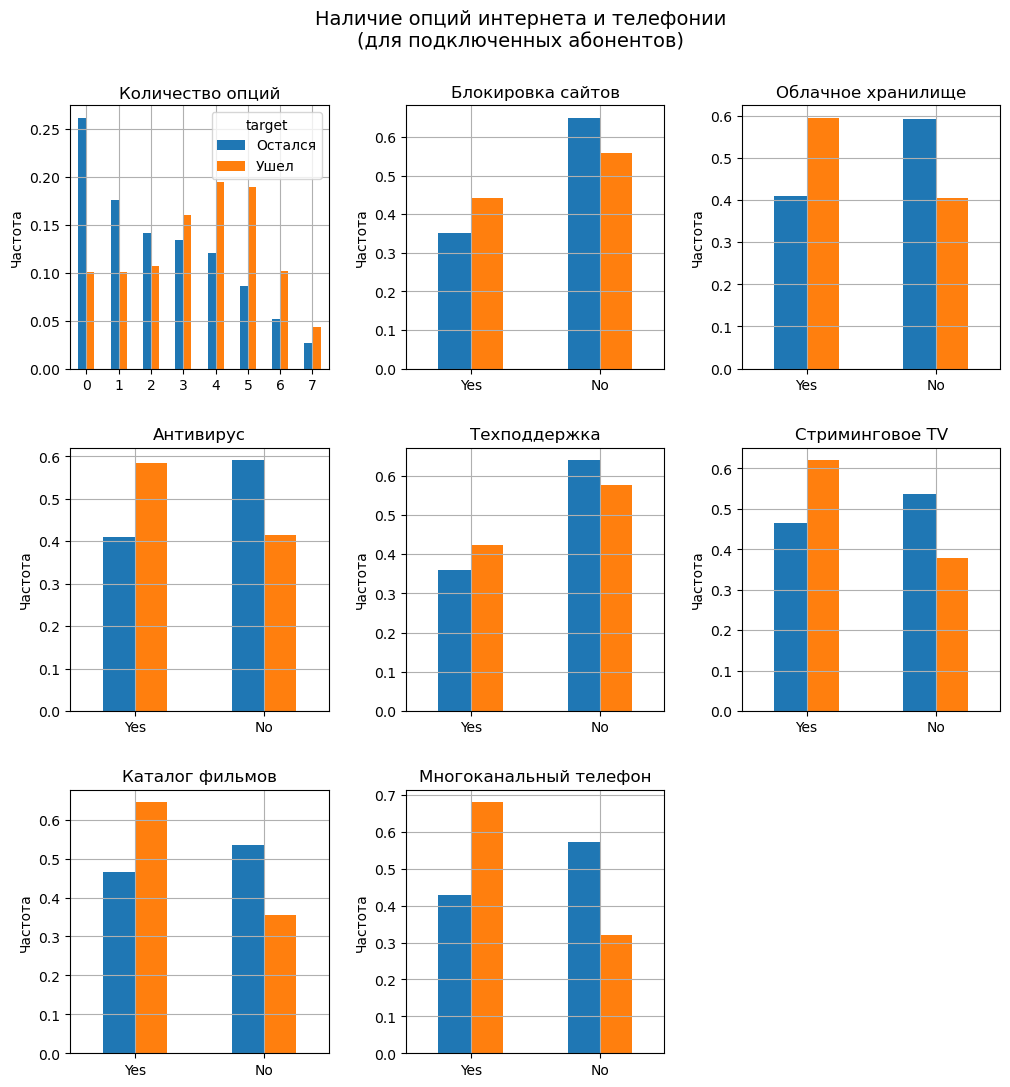

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

bar_target(data, 'option_count', axes[0][0], 'Количество опций', ascending=True, legend=True)

inet_data = data[data['internet_service'] != 'No']
bar_target(inet_data, 'online_security', axes[0][1], 'Блокировка сайтов')
bar_target(inet_data, 'online_backup', axes[0][2], 'Облачное хранилище')
bar_target(inet_data, 'device_protection', axes[1][0], 'Антивирус')
bar_target(inet_data, 'tech_support', axes[1][1], 'Техподдержка')
bar_target(inet_data, 'streaming_tv', axes[1][2], 'Стриминговое TV')
bar_target(inet_data, 'streaming_movies', axes[2][0], 'Каталог фильмов')

phone_data = data[data['phone'] == 'Yes']
bar_target(phone_data, 'multiple_lines', axes[2][1], 'Многоканальный телефон')
axes[2][2].set_visible(False)

fig.suptitle('Наличие опций интернета и телефонии\n(для подключенных абонентов)', fontsize=14)
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)
plt.show()

### Корреляция

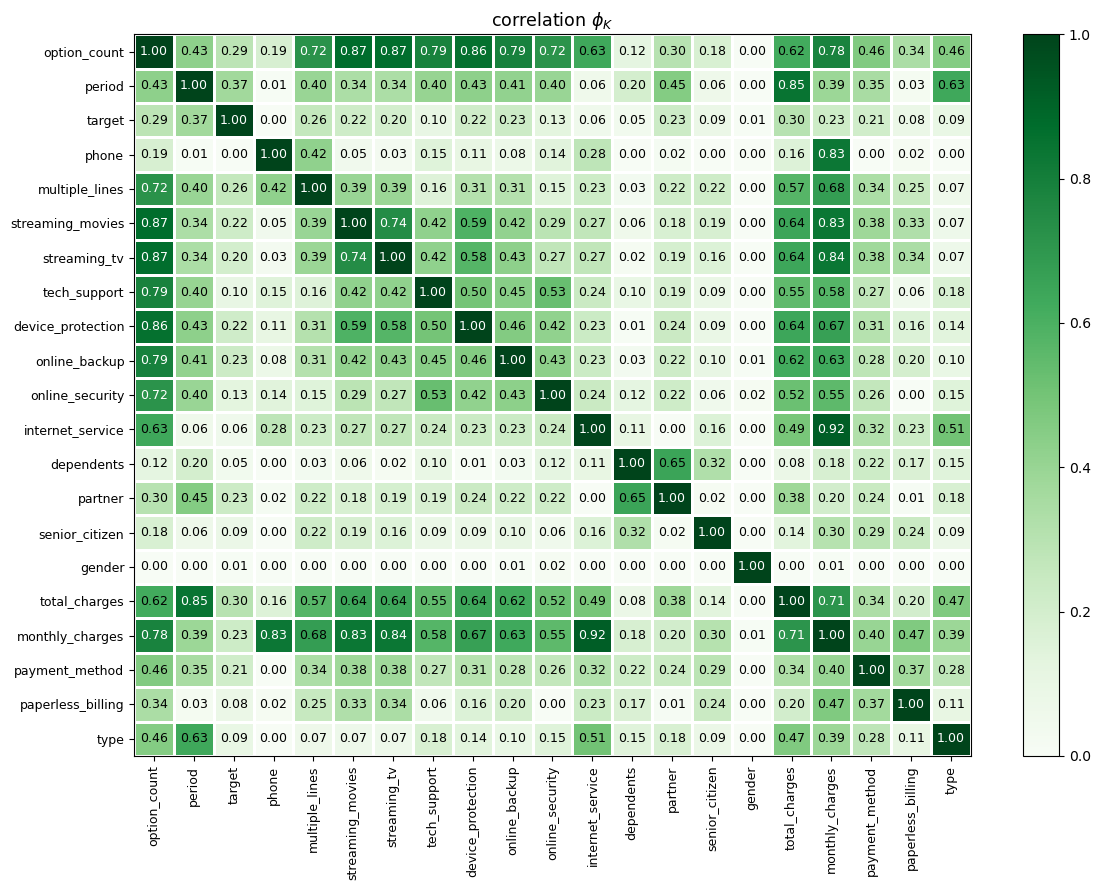

In [34]:
cols = data.select_dtypes(exclude=['datetime64']).columns
interval_cols = data.select_dtypes(include=['number']).columns

phik_overview = data[cols].phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9,
                        figsize=(12, 9))
plt.tight_layout()

### Выводы

- Объединенный датафрейм содержит информацию о договорах, клиентах, услугах подключения интернета и телефонии.
- Все пустые столбцы заполнены.
- Добавлены новые столбцы (признаки): `period`, `phone`, `option_count`, `target`, где последний является целевой переменной для моделей машинного обучения.
- Аномальные значения в числовых столбцах отсутствуют.
- Количества оставшихся и ушедших клиентов находятся в примерном соотношении 5 к 1.
- Распределения признаков в разрезе целевой переменной:
    - Наиболее отличаются распределения периода, количества доп. услуг и расходов.
    - Для ушедших клиентов в целом характерны более высокие расходы.
    - Большинство других признаков имеют очень похожие распределения.
- Корреляции:
    - Нет существенных связей целевой переменной с другими признаками.
    - Наиболее высокие значения показывают общие и ежемесячные расходы.
    - Самые низкие значения у признака пола.
    - Дополнительные услуги интернета и телефонии (опции):
        - опции высоко коррелированы с расходами;
        - есть высокая корреляция между опциями и их количеством;
        - можно рассмотреть вариант исключения опций из обучения моделей.


## Подготовка данных

### Выбор признаков
- Признаки дата начала `begin_date` и дата окончания `end_date` использовать нельзя, т.к. будет утечка целевого признака.
- Не будем использовать опции подключения интернета и телефонии, вместо них возьмем количество подключенных опций.
- Категориальные признаки приведем к типу *category* - для удобства их использования в модели LightGBMClassifier.

In [35]:
target = data['target']
features = data.drop(columns=(['begin_date', 'end_date', 'target'] + option_cols))

num_feature_names = features.columns[features.dtypes != 'object']
cat_feature_names = features.columns[features.dtypes == 'object']

for col in cat_feature_names:
    features[col] = features[col].astype('category')

### Разделение на train / test

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    stratify=data['target'],
    random_state=RANDOM_STATE)

## Обучение моделей

In [37]:
def get_result_series(gs):
    '''
    Получение результата кросс-валиадации в виде pandas series
    '''
    res_keys = ['mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']
    res_cols = ['AUC-ROC', 'AUC-ROC std', 'Accuracy', 'Accuracy std']
    res = pd.DataFrame(
        {res_cols[i]: gs.cv_results_[key] for i, key in enumerate(res_keys)}
    )
    return res.iloc[gs.best_index_]

def view_result(gs):
    '''
    Отображение результата обучения модели
    '''
    res = pd.DataFrame(data=get_result_series(gs))
    res.columns = ['Value']
    display(res)
    print('Best params:', gs.best_params_)

In [38]:
def feat_plot(feat_imp, limit=30, label=''):
    '''
    Отрисовка графика matplotlib
    '''
    feat_imp.nlargest(limit).plot(
        kind='barh',
        figsize=(6, 4),
        grid=True,
        title='Важность признаков').set_xlabel(label)
    plt.show()    

    
def importance_plot(estimator):
    '''
    Отображение графика значимости признаков
    '''
    feat_imp = pd.Series(
        estimator.feature_importances_,
        index=estimator.feature_name_)
    feat_plot(
        feat_imp,
        label='Сколько раз признак использовался в модели\n(importance_type="split")')


def rf_importance_plot(estimator, feature_names):
    '''
    Отображение графика значимости признаков для случайного леса
    '''
    feat_imp = pd.Series(estimator.feature_importances_)
    feat_imp.index = feat_imp.index.map(lambda x: feature_names[x])
    feat_plot(feat_imp, label='gini')

### DummyClassifier
Используется GridSearchCV исключительно для удобства отображения результатов (единообразно с другими моделями). Другой необходимости использования подбора параметров по сетке для константной модели нет.

In [39]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_gs = GridSearchCV(
    dummy_model,
    param_grid={},
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc',
    cv=2,
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

dummy_gs.fit(X_train, y_train)

view_result(dummy_gs)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


,Value
AUC-ROC,0.499875
AUC-ROC std,0.001435
Accuracy,0.731920
Accuracy std,0.000757


Best params: {}


### RidgeClassifier

In [40]:
%%time

ridge_col_transformer = ColumnTransformer(
    [
        ("num_pre_scaler", StandardScaler(), num_feature_names),
        ("cat_pre_ohe", OneHotEncoder(handle_unknown='ignore'), cat_feature_names)
    ],
    remainder='passthrough'
)

ridge_model = RidgeClassifier(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE)

ridge_pipeline = Pipeline(steps=[
    ('preprocessing', ridge_col_transformer),
    ('classification', ridge_model)
])

ridge_param_grid = {
    'classification__alpha': [0.005, 0.5, 1, 5, 10, 20]
}

ridge_gs = GridSearchCV(
    ridge_pipeline,
    param_grid=ridge_param_grid,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

ridge_gs.fit(X_train, y_train)
view_result(ridge_gs)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,Value
AUC-ROC,0.757721
AUC-ROC std,0.013291
Accuracy,0.692348
Accuracy std,0.012122


Best params: {'classification__alpha': 10}
CPU times: total: 250 ms
Wall time: 660 ms


### RandomForestClassifier

In [41]:
%%time

rf_col_transformer = ColumnTransformer(
    [
        (
            "cat_pre_ord",
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            cat_feature_names
        )
    ],
    remainder='passthrough'
)

rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

rf_pipeline = Pipeline(steps=[
    ('preprocessing', rf_col_transformer),
    ('classification', rf_model)
])

rf_param_grid = {
    'classification__n_estimators': range(50, 151, 10),
    'classification__max_depth': range(2, 15),
    'classification__min_samples_split': (2, 3, 4),
    'classification__min_samples_leaf': (2, 3, 4)
}

# Небольшое количество итераций для экономии времени
rf_gs = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=10,
    random_state=RANDOM_STATE,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

rf_gs.fit(X_train, y_train)

view_result(rf_gs)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,Value
AUC-ROC,0.815120
AUC-ROC std,0.010642
Accuracy,0.760887
Accuracy std,0.004583


Best params: {'classification__n_estimators': 120, 'classification__min_samples_split': 4, 'classification__min_samples_leaf': 4, 'classification__max_depth': 7}
CPU times: total: 1.31 s
Wall time: 5.45 s


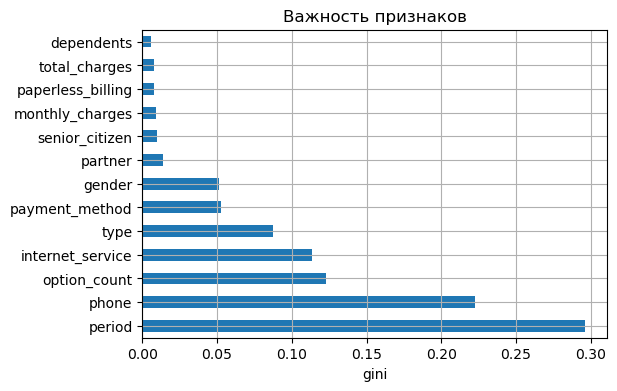

In [42]:
rf_importance_plot(rf_gs.best_estimator_[-1], X_train.columns)

### LightGBMClassifier

In [43]:
%%time

light_model = LGBMClassifier(is_unbalance=True,
                             random_state=RANDOM_STATE,
                             force_row_wise=True)

light_param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.05, 0.1]
}

light_gs = GridSearchCV(
    light_model,
    param_grid=light_param_grid,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

light_gs.fit(X_train, y_train)

view_result(light_gs)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412


,Value
AUC-ROC,0.860528
AUC-ROC std,0.008716
Accuracy,0.866908
Accuracy std,0.005803


Best params: {'learning_rate': 0.05, 'n_estimators': 500}
CPU times: total: 2 s
Wall time: 8.89 s


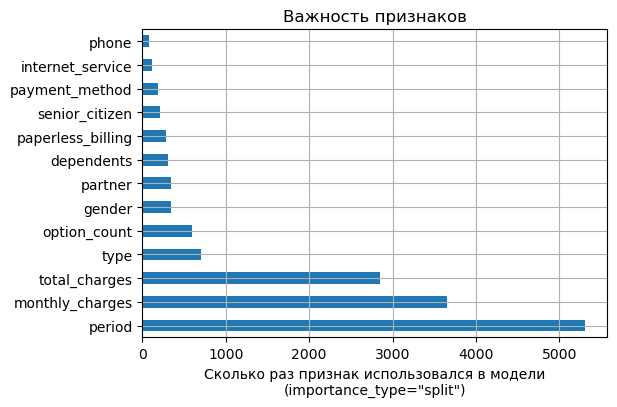

In [44]:
importance_plot(light_gs.best_estimator_)

### Лучшая модель

In [45]:
pd.DataFrame(
    data=[get_result_series(gs) for gs in [dummy_gs, ridge_gs, rf_gs, light_gs]],
    index=['Dummy', 'Ridge', 'Random Forest', 'Light GBM']
).sort_values(by='AUC-ROC', ascending=False)

,AUC-ROC,AUC-ROC std,Accuracy,Accuracy std
Light GBM,0.860528,0.008716,0.866908,0.005803
Random Forest,0.815120,0.010642,0.760887,0.004583
Ridge,0.757721,0.013291,0.692348,0.012122
Dummy,0.499875,0.001435,0.731920,0.000757


LGBMClassifier - лучшая модель с самыми высокими значениями AUC-ROC и Accuracy.

### Тестирование

In [46]:
def test(X_test, y_test, estimator, name):
    '''
    Функция объединяющая весь процесс тестирования
    '''
    probabilities_one = estimator.predict_proba(X_test)[:, 1]
    auc_metric = roc_auc_score(y_test, probabilities_one)
    print(f'AUC-ROC: {auc_metric:.3f}')
    
    y_pred = estimator.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    
    if auc_metric < TEST_THRESHOLD:
        print(f'Модель {name} не прошла тестирование :-(')
    else:
        print(f'Модель {name} прошла тестирование')
        
    # Отобразим некоторые результаты визуально
    fig, (ax_auc, ax_mtx) = plt.subplots(1, 2, figsize=(12, 4))
        
    # Рассчитаем параметры ROC-кривой
    fpr, tpr, _ = roc_curve(y_test, probabilities_one)

    # Построим график ROC-кривой
    roc_display = RocCurveDisplay(fpr=fpr,
                                  tpr=tpr,
                                  roc_auc=auc_metric,
                                  estimator_name='ROC-кривая')
    ax_auc.set_title('ROC-кривая')
    roc_display.plot(ax_auc)
    
    # Построим матрицу ошибок
    ax_mtx.set_title('Матрица ошибок')
    ConfusionMatrixDisplay.from_estimator(
        estimator,
        X_test,
        y_test,
        ax=ax_mtx,
        normalize='all',
        cmap=plt.cm.Blues
    )

    plt.show()

AUC-ROC: 0.906
Accuracy: 0.876
Модель LGBMClassifier прошла тестирование


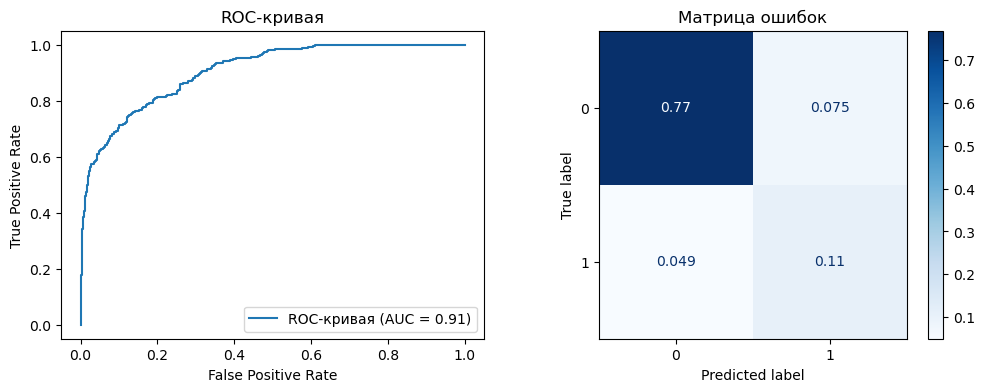

In [47]:
test(X_test, y_test, light_gs, 'LGBMClassifier')

### Выводы

- Были использованы три типа моделей: линейная, случайный лес и градиентный бустинг.
- Целевой признак имеет дисбаланс классов: все модели учитывали это в соответствующих гиперпараметрах.
- Лучшая модель - LightGBMClassifier. Другие модели не превысили пороговую метрику.
- Модель адекватна - ее метрика превосходит метрику константной модели.
- Модель прошла тестирование и показала высокие результаты: AUC-ROC: 0.906, Accuracy: 0.876
- Матрица ошибок:
    - ложноположительные результаты составляют 7.5%, что составляет 8.9% ошибочных прогнозов для оставшихся клиентов;
    - ложноотрицательные результаты составляют 4.9%, что составляет 30.8% ошибочных прогнозов для ушедших клиентов.

## Общий вывод

### Краткий обзор проведённой работы

- Загружены четыре набора данных: клиенты, договоры, услуги интернета, подключение к телефонии.
- Наборы объединены в единый датафрейм.
- Проведена предобработка данных:
    - изменен стиль наименования столбцов на CamelCase;
    - изменены типы данных столбца общих расходов, дат начала и окончания договора;
    - заполнены пустые столбцы дополнительных услуг подключений (опции), общих расходов;
    - добавлены следующие поля: длительность договора, наличие телефона, количество подключенных доп. услуг, целевая переменная (клиент ушел / остался).
- Проведен исследовательский анализ данных, где были изучены:
    - охват клиентов услугами;
    - распределения признаков;
    - корреляция между признаками;
- Составлен портрет ушедшего пользователя для главного вывода.
- Подготовлены данные для машинного обучения, отобраны признаки.
- Обучены 4 модели классификации: константная, линейная, случайный лес, градиентный бустинг.
- Выбрана лучшая модель.
- Проведено тестирование лучшей модели.
- Проанализированы результаты теста.

### Главные выводы

- Все клиенты имеют договора, не все клиенты имеют подключение к интернету, не все подключены к услуге телефонии.
- Количества оставшихся и ушедших клиентов находятся в примерном соотношении 5 к 1.
- Распределения признаков в разрезе целевой переменной:
    - наиболее отличаются распределения периода, количества доп. услуг и расходов;
    - для ушедших клиентов в целом характерны более высокие расходы;
    - большинство других признаков имеют очень похожие распределения.
- Корреляции:
    - нет существенных связей целевой переменной с другими признаками;
    - наиболее высокие значения корреляции показывают общие и ежемесячные расходы;
    - самые низкие значения у признака пола.
- Типичный портрет ушедшего пользователя:
    - пользуется услугами оператора связи от полутора до четырех лет (средний период);
    - количество подключенных опций от 3 до 5;
    - имеет высокие ежемесячные и общие расходы;
    - вероятнее всего имеет супруга (супругу).
- Машинное обучение:
    - лучшая модель - LightGBMClassifier: из семейства моделей градиентного бустинга над решающими деревьями;
    - метрики модели превышают метрики константной модели;
    - модель проходит тестирование: ее метрика AUC-ROC равняется 0.906 и превышают порог в 0.85, значение Accuracy равно 0.876;
    - ложноположительные результаты составляют 7.5% от общего количества тестируемых клиентов или 8.9% от оставшихся клиентов;
    - ложноотрицательные результаты составляют 4.9% от общего количества тестируемых клиентов или 30.8% от ушедших.
- Решена основная задача - на имеющихся данных можно обучить модель градиентного бустинга и предсказать отток клиентов с высокой точностью.

### Рекомендации
- Внедрить систему предсказания оттока клиентов у оператора связи.
- Дополнительно проводить регулярные опросы, помогающие определять лояльность клиентов и выявлять рискованных. Возможно, результаты этих опросов включить в обучение моделей предсказания оттока.
- Разработать систему удержания рискованных клиентов, провести А/Б тестирование системы.
- Возможные варианты удерживания:
    - за большое количество подключенных дополнительных услуг предлагать скидки;
    - доп. услуги объединять в удобные для пользователя пакеты;
    - проводить акции, розыгрыши ценных призов.
- Рекомендации общего плана:
    - повышать качество услуг;
    - следить за действиями конкурентов, т.к. при наличии даже самой идеальной модели предсказания оттока, клиенты будут уходить к операторам с более выгодными условиями.